In [88]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import torch

In [89]:
def extract_topic_name(flight_name, file_name):
    topic_name = file_name.split(flight_name)
    topic_name =  topic_name[1].strip("-") if len(topic_name)>1 else ""
    topic_name = topic_name.split(".csv")[0]
    return topic_name

In [90]:
def read_data(full_path):
    df_tmp = pd.read_csv(full_path,on_bad_lines="skip")
    df_tmp = df_tmp.rename(columns={"%time": "timestamp"})
    
    df_tmp["timestamp"] = pd.to_datetime(df_tmp["timestamp"], unit="ns")
    df_tmp.set_index("timestamp", inplace=True) 
    return df_tmp


In [91]:
data_path = "./data/processed/"

In [92]:
unused_topic_list = ["diagnostics", "emergency_responder-traj_file","mavlink-from","mavros-state",
                    "global_position",
                     "local_position", 
                     "mavctrl-rpy",
                     "mavros-battery", "field_raw",
                     "mavros-imu-mag", "mavros-mission-reached",
                     "mavros-rc",
                      "setpoint_raw","mavros-imu-data_raw"]

unused_column_list = ["field.header.seq", "field.header.stamp", "field.header.frame_id", 
                      "field.commanded", "field.variance", "%time","field.x","field.twist.angular.x","field.twist.angular.y","field.twist.angular.z",
                      'field.orientation_covariance0',
       'field.orientation_covariance1',
       'field.orientation_covariance2',
       'field.orientation_covariance3',
       'field.orientation_covariance4',
       'field.orientation_covariance5',
       'field.orientation_covariance6',
       'field.orientation_covariance7',
       'field.orientation_covariance8',

       'field.angular_velocity_covariance0',
       'field.angular_velocity_covariance1',
       'field.angular_velocity_covariance2',
       'field.angular_velocity_covariance3',
       'field.angular_velocity_covariance4',
       'field.angular_velocity_covariance5',
       'field.angular_velocity_covariance6',
       'field.angular_velocity_covariance7',
       'field.angular_velocity_covariance8',

       'field.linear_acceleration_covariance0',
       'field.linear_acceleration_covariance1',
       'field.linear_acceleration_covariance2',
       'field.linear_acceleration_covariance3',
       'field.linear_acceleration_covariance4',
       'field.linear_acceleration_covariance5',
       'field.linear_acceleration_covariance6',
       'field.linear_acceleration_covariance7',
       'field.linear_acceleration_covariance8',
       "field.coordinate_frame","field.source"]

In [93]:
print(os.getcwd())
print(os.listdir())

c:\Users\hy138\Desktop\UAV
['.vscode', 'best_model.pth', 'BiLSTM.ipynb', 'BiLSTMs.ipynb', 'CNN1D.ipynb', 'CNN1Ds.ipynb', 'data', 'LSTM copy.ipynb', 'LSTM.ipynb', 'LSTMAutoEncoder.ipynb', 'LSTMs.ipynb', 'mLSTM.ipynb', 'sLSTM.ipynb', 'xLSTM.ipynb', 'Yeni klasör']


In [94]:
time_dict = {}
flight_topic_list = []
topic_list = []
all_columns = []
df_dict = {}
failure_status_dict = {}

In [95]:
print(topic_list)

[]


In [96]:
for i,flight in enumerate(glob.glob(data_path+"*")):
    
    flight_name = os.path.basename(flight)
    
    if "no_ground_truth" in flight_name:
        continue
    if "no_failure" in flight_name:
            continue
    # This folder has not path-dev csv file
    if "carbonZ_2018-09-11-15-06-34_3_rudder_left_failure" in flight_name:
        continue
    print(flight_name)

    if flight_name not in flight_topic_list:
        flight_topic_list.append(flight_name)
    

    df_failure = None
    failure_duration_start = pd.Timestamp('1970-01-01')
    failure_duration_finish = pd.Timestamp('1970-01-01')

    dfs = list()
    for i , file in enumerate(glob.glob(os.path.join(data_path,flight_name,"*.csv"))):
        
        if any(x in file for x in unused_topic_list):
            continue
        

        if "failure_status" in os.path.basename(file):
            file_name = os.path.basename(file)
            
            df = read_data(file)
            topic_name = extract_topic_name(flight_name,file_name)

            
            failure_duration_start = min(df.index)
            failure_duration_end = max(df.index)

            failure_status_dict[flight_name] = (failure_duration_start,failure_duration_end)

            continue
        
        file_name = os.path.basename(file)

        df = read_data(file)
        topic_name = extract_topic_name(flight_name,file_name)
        for col in unused_column_list:
            if col in df.columns:
                df.drop(col,axis=1,inplace=True)
        new_columns = list(map(lambda x: f"{topic_name}.{x.replace('field.', '')}", df.columns))
        df = df.set_axis(new_columns, axis=1)
       
     
        
        dfs.append(df)

   
    df_dict[flight_name] = dfs

    

carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-51_elevator_failure
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
carbonZ_2018-09-11-15-05-11_1_elevator_failure
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
carbonZ_2018-09-11-15-06-34_2_rudder_right_failure
carbonZ_2018-09-11-17-27-13

In [97]:
len(df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"])

13

In [98]:
len(df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][0]),df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][0].isna().sum()

(6619,
 mavctrl-path_dev.y    0
 mavctrl-path_dev.z    0
 dtype: int64)

In [99]:
failure_status_dict

{'carbonZ_2018-07-18-15-53-31_1_engine_failure': (Timestamp('2018-07-18 19:58:47.129305993'),
  Timestamp('2018-07-18 19:59:03.134074845')),
 'carbonZ_2018-07-18-15-53-31_2_engine_failure': (Timestamp('2018-07-18 20:01:44.729304590'),
  Timestamp('2018-07-18 20:01:59.928010526')),
 'carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj': (Timestamp('2018-07-18 20:32:26.878396465'),
  Timestamp('2018-07-18 20:32:42.672828037')),
 'carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj': (Timestamp('2018-07-18 20:46:37.888445250'),
  Timestamp('2018-07-18 20:46:54.288954056')),
 'carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj': (Timestamp('2018-07-21 00:35:22.170194'),
  Timestamp('2018-07-21 00:35:41.166058768')),
 'carbonZ_2018-07-30-16-39-00_1_engine_failure': (Timestamp('2018-07-21 01:00:21.380769776'),
  Timestamp('2018-07-21 01:00:36.175981200')),
 'carbonZ_2018-07-30-16-39-00_2_engine_failure': (Timestamp('2018-07-21 01:04:00.575490608'),
  Timestamp('2018-07-21 0

In [100]:
# for key,data in df_dict.items():
#     df_list = []
#     for df in data:
#         for col in df.columns:
#             df[f'{col}_copy'] = df[col] 
    
#         df_list.append(df)
#     df_dict[key] = df_list

In [101]:
for key, df in df_dict.items():
    print(key)
    print(len(df))

carbonZ_2018-07-18-15-53-31_1_engine_failure
13
carbonZ_2018-07-18-15-53-31_2_engine_failure
13
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-39-00_1_engine_failure
13
carbonZ_2018-07-30-16-39-00_2_engine_failure
13
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
13
carbonZ_2018-09-11-11-56-30_engine_failure
13
carbonZ_2018-09-11-14-22-07_1_engine_failure
13
carbonZ_2018-09-11-14-22-07_2_engine_failure
13
carbonZ_2018-09-11-14-41-51_elevator_failure
13
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
13
carbonZ_2018-09-11-15-05-11_1_elevator_failure
13
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
13
carbonZ_2018-09-11-15-06

In [102]:
for key, data in df_dict.items():
    if "rudder_zero__left_aileron_failure" in key:
        

        df_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"] = df_dict['carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure'].copy()
 
 

        df_dict["carbonZ_2018-09-11-17-27-13_1_left_aileron_failure"] = df_dict['carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure'].copy()

   

        del df_dict['carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure']


        break
 


In [103]:
for key, df in df_dict.items():
    print(key)
    print(len(df))

carbonZ_2018-07-18-15-53-31_1_engine_failure
13
carbonZ_2018-07-18-15-53-31_2_engine_failure
13
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-39-00_1_engine_failure
13
carbonZ_2018-07-30-16-39-00_2_engine_failure
13
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
13
carbonZ_2018-09-11-11-56-30_engine_failure
13
carbonZ_2018-09-11-14-22-07_1_engine_failure
13
carbonZ_2018-09-11-14-22-07_2_engine_failure
13
carbonZ_2018-09-11-14-41-51_elevator_failure
13
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
13
carbonZ_2018-09-11-15-05-11_1_elevator_failure
13
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
13
carbonZ_2018-09-11-15-06

In [104]:
for key, data in failure_status_dict.items():
    if "rudder_zero__left_aileron_failure" in key:
        failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"] = failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure"]
        failure_status_dict["carbonZ_2018-09-11-17-27-13_1_left_aileron_failure"] = failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure"]
        del failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure"]
        break

In [105]:
df_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"][1].columns

Index(['mavros-imu-atm_pressure.fluid_pressure'], dtype='object')

In [106]:
df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][0]

,mavctrl-path_dev.y,mavctrl-path_dev.z
timestamp,,
2018-07-18 19:56:50.820860792,141.284886,14.438259
2018-07-18 19:56:50.840917944,141.284886,14.438259
2018-07-18 19:56:50.861388914,141.284886,14.438259
2018-07-18 19:56:50.880812090,141.284886,14.438259
2018-07-18 19:56:50.901712334,144.798264,14.394005
...,...,...
2018-07-18 19:59:03.108804965,8.337481,21.670137
2018-07-18 19:59:03.130722624,8.337481,21.670137
2018-07-18 19:59:03.149511356,8.337481,21.670137


In [107]:
flight_topic_list.append("carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure")
flight_topic_list.append("carbonZ_2018-09-11-17-27-13_1_left_aileron_failure")
flight_topic_list.remove("carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure")


In [108]:
len(flight_topic_list)

36

In [109]:
failure_status_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"]

(Timestamp('2018-07-18 19:58:47.129305993'),
 Timestamp('2018-07-18 19:59:03.134074845'))

In [110]:
df = df_dict["carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure"]
df

[                               mavctrl-path_dev.y  mavctrl-path_dev.z
 timestamp                                                            
 2018-09-11 18:55:44.748852696          226.349940          -16.530594
 2018-09-11 18:55:44.768693912          226.349940          -16.530594
 2018-09-11 18:55:44.793884088          207.499653          -16.530594
 2018-09-11 18:55:44.809683352          207.499366          -16.530594
 2018-09-11 18:55:44.831660792          207.499366          -16.530594
 ...                                           ...                 ...
 2018-09-11 18:59:38.029159576            5.033987            3.622774
 2018-09-11 18:59:38.049874936            5.033987            3.622774
 2018-09-11 18:59:38.073666904            5.033987            3.622774
 2018-09-11 18:59:38.089277368            4.698973            4.732197
 2018-09-11 18:59:38.109449304            4.698973            4.732197
 
 [11669 rows x 2 columns],
                                mavros-imu-atm_p

Failure Status:
    
    Engine     = 1
    Rudder     = 2
    Aileron    = 3
    Elevator   = 4

In [111]:
def add_failure(flight_name,df_failure,failure_duration_start,failure_duration_end):
    if "engine" in flight_name:
        failure_status = [
        1 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
    elif "rudder" in flight_name:
        failure_status = [
        2 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
    elif "aileron" in flight_name:
        failure_status = [
        3 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
    elif "elevator" in flight_name:
        failure_status = [
        4 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
        
    df_failure["failure_status"] = failure_status
        
    return df_failure

In [112]:
flight_topic_list

['carbonZ_2018-07-18-15-53-31_1_engine_failure',
 'carbonZ_2018-07-18-15-53-31_2_engine_failure',
 'carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj',
 'carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-16-39-00_1_engine_failure',
 'carbonZ_2018-07-30-16-39-00_2_engine_failure',
 'carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj',
 'carbonZ_2018-09-11-11-56-30_engine_failure',
 'carbonZ_2018-09-11-14-22-07_1_engine_failure',
 'carbonZ_2018-09-11-14-22-07_2_engine_failure',
 'carbonZ_2018-09-11-14-41-51_elevator_failure',
 'carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure',
 'carbonZ_2018-09-11-15-05-11_1_elevator_failure',
 'carbonZ_2018-09-11-15-06-34_1_rudder_right_failure',
 'carb

In [113]:
for flight_name in flight_topic_list:
    print(flight_name)
    dfs = df_dict[flight_name] 
    
    start_time = min(min(dfs[0].index),min(dfs[1].index),min(dfs[2].index),min(dfs[3].index),min(dfs[4].index),min(dfs[5].index),min(dfs[6].index),min(dfs[7].index),min(dfs[8].index),min(dfs[9].index),min(dfs[10].index),min(dfs[11].index),min(dfs[12].index))
    end_time = max(max(dfs[0].index),max(dfs[1].index),max(dfs[2].index),max(dfs[3].index),max(dfs[4].index),max(dfs[5].index),max(dfs[6].index),max(dfs[7].index),max(dfs[8].index),max(dfs[9].index),max(dfs[10].index),max(dfs[11].index),max(dfs[12].index))
    
    time_index = pd.date_range(start=start_time, end=end_time, freq="200ms")  
    data = [0] * len(time_index)

    df_failure = pd.DataFrame(data, index=time_index, columns=["failure_status"])

    failure_duration_start = failure_status_dict[flight_name][0]
    failure_duration_end   = failure_status_dict[flight_name][1]
    
    
    df_dict[flight_name].append(add_failure(flight_name,df_failure,failure_duration_start,failure_duration_end))

carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-51_elevator_failure
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
carbonZ_2018-09-11-15-05-11_1_elevator_failure
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
carbonZ_2018-09-11-15-06-34_2_rudder_right_failure
carbonZ_2018-09-11-17-27-13

In [114]:
df = df_dict["carbonZ_2018-09-11-17-27-13_1_left_aileron_failure"]
df[12].iloc[: , :]

,mavros-wind_estimation.twist.linear.x,mavros-wind_estimation.twist.linear.y,mavros-wind_estimation.twist.linear.z
timestamp,,,
2018-09-11 21:34:19.188548395,0.360470,1.439026,0.0
2018-09-11 21:34:19.566847897,0.352583,1.463511,0.0
2018-09-11 21:34:19.954091484,0.345375,1.496819,0.0
2018-09-11 21:34:20.421941571,0.328750,1.548180,0.0
2018-09-11 21:34:20.868431200,0.321009,1.588851,0.0
...,...,...,...
2018-09-11 21:36:40.589048991,-0.256345,2.252147,0.0
2018-09-11 21:36:40.936268682,-0.255210,2.252631,0.0
2018-09-11 21:36:41.422716742,-0.253657,2.253724,0.0


In [115]:
df = df_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"]
df[12]


,mavros-wind_estimation.twist.linear.x,mavros-wind_estimation.twist.linear.y,mavros-wind_estimation.twist.linear.z
timestamp,,,
2018-09-11 21:34:19.188548395,0.360470,1.439026,0.0
2018-09-11 21:34:19.566847897,0.352583,1.463511,0.0
2018-09-11 21:34:19.954091484,0.345375,1.496819,0.0
2018-09-11 21:34:20.421941571,0.328750,1.548180,0.0
2018-09-11 21:34:20.868431200,0.321009,1.588851,0.0
...,...,...,...
2018-09-11 21:36:40.589048991,-0.256345,2.252147,0.0
2018-09-11 21:36:40.936268682,-0.255210,2.252631,0.0
2018-09-11 21:36:41.422716742,-0.253657,2.253724,0.0


In [116]:
for key, df in df_dict.items():
    print(key)
    print(len(df))

carbonZ_2018-07-18-15-53-31_1_engine_failure
14
carbonZ_2018-07-18-15-53-31_2_engine_failure
14
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
14
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-16-39-00_1_engine_failure
14
carbonZ_2018-07-30-16-39-00_2_engine_failure
14
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
14
carbonZ_2018-09-11-11-56-30_engine_failure
14
carbonZ_2018-09-11-14-22-07_1_engine_failure
14
carbonZ_2018-09-11-14-22-07_2_engine_failure
14
carbonZ_2018-09-11-14-41-51_elevator_failure
14
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
14
carbonZ_2018-09-11-15-05-11_1_elevator_failure
14
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
14
carbonZ_2018-09-11-15-06

Birleştirme:

In [117]:
df = df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][1]
df

,mavros-imu-atm_pressure.fluid_pressure
timestamp,
2018-07-18 19:56:50.883316762,97310.498047
2018-07-18 19:56:50.958577559,97310.498047
2018-07-18 19:56:51.062952770,97329.193115
2018-07-18 19:56:51.153503583,97341.693115
2018-07-18 19:56:51.245127118,97329.223633
...,...
2018-07-18 19:59:02.784104260,97410.662842
2018-07-18 19:59:02.886696084,97414.984131
2018-07-18 19:59:02.954867820,97414.984131


In [118]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

scaler = StandardScaler()

w_label = 66
s_label = 6

window_sizes = [661, 132, 32, 132, 247, 253, 253, 253, 247, 253, 27, 32, 27]
step_sizes =   [66, 13, 3, 13, 24, 25, 25, 25, 24, 25, 2, 3, 2]

x_arrays = [np.zeros((0, w, c)) for w, c in zip(window_sizes, [2, 1, 10, 1, 1, 4, 1, 1, 6, 1, 1, 6, 3])]
y = []

for key, data in df_dict.items():
    print(key)
    
    scaled_data = [pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index).dropna() for df in data[:-1]]
    labels_data = data[-1]

    len_label = len(labels_data)
    len_data = [len(df) for df in scaled_data]

    while all(len_d - w >= 0 for len_d, w in zip(len_data, window_sizes)):
        labels = labels_data[len_label - w_label : len_label].values
        len_label -= s_label

        slices = [df[len_d - w : len_d].values for df, len_d, w in zip(scaled_data, len_data, window_sizes)]
        reshaped_slices = [
            sl.reshape(-1, w, c) for sl, w, c in zip(slices, window_sizes, [2, 1, 10, 1, 1, 4, 1, 1, 6, 1, 1, 6, 3])
        ]
        len_data = [len_d - s for len_d, s in zip(len_data, step_sizes)]

        if 2 in labels:
            repeat_count = 4
        elif 3 in labels:
            repeat_count = 3
        elif 4 in labels:
            repeat_count = 5
        else:
            repeat_count = 1
        
        for _ in range(repeat_count):
            for i, sl in enumerate(reshaped_slices):
                x_arrays[i] = np.vstack((x_arrays[i], sl))
            y.append(labels)


carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-51_elevator_failure
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
carbonZ_2018-09-11-15-05-11_1_elevator_failure
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
carbonZ_2018-09-11-15-06-34_2_rudder_right_failure
carbonZ_2018-09-11-17-27-13

In [119]:
shapes = [x.shape for x in x_arrays]
shapes

[(3666, 661, 2),
 (3666, 132, 1),
 (3666, 32, 10),
 (3666, 132, 1),
 (3666, 247, 1),
 (3666, 253, 4),
 (3666, 253, 1),
 (3666, 253, 1),
 (3666, 247, 6),
 (3666, 253, 1),
 (3666, 27, 1),
 (3666, 32, 6),
 (3666, 27, 3)]

In [120]:
x_arrays[9][495][-1]

array([-1.2548107])

In [121]:
len(y)

3666

In [122]:
y = np.array(y)
y_ = np.array([max(m) for m in y])
y_.shape,y.shape

((3666, 1), (3666, 66, 1))

In [123]:
import random 

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


set_seed(42)

In [124]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, x_arrays, y):
        self.x0 = torch.tensor(x_arrays[0], dtype=torch.float32)
        self.x1 = torch.tensor(x_arrays[1], dtype=torch.float32)
        self.x2 = torch.tensor(x_arrays[2], dtype=torch.float32)
        self.x3 = torch.tensor(x_arrays[3], dtype=torch.float32)
        self.x4 = torch.tensor(x_arrays[4], dtype=torch.float32)
        self.x5 = torch.tensor(x_arrays[5], dtype=torch.float32)
        self.x6 = torch.tensor(x_arrays[6], dtype=torch.float32)
        self.x7 = torch.tensor(x_arrays[7], dtype=torch.float32)
        self.x8 = torch.tensor(x_arrays[8], dtype=torch.float32)
        self.x9 = torch.tensor(x_arrays[9], dtype=torch.float32)
        self.x10 = torch.tensor(x_arrays[10], dtype=torch.float32)
        self.x11 = torch.tensor(x_arrays[11], dtype=torch.float32)
        self.x12 = torch.tensor(x_arrays[12], dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long).squeeze()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            self.x0[idx], self.x1[idx], self.x2[idx], self.x3[idx], self.x4[idx],
            self.x5[idx], self.x6[idx], self.x7[idx], self.x8[idx], self.x9[idx],
            self.x10[idx], self.x11[idx], self.x12[idx], self.y[idx]
        )

dataset = CustomDataset(x_arrays, y_)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch in train_dataloader:
    (
        x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, 
        x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, 
        x10_batch, x11_batch, x12_batch, y_batch
    ) = batch
    print("Train batch shapes:", x0_batch.shape, x1_batch.shape, x2_batch.shape, x3_batch.shape, 
          x4_batch.shape, x5_batch.shape, x6_batch.shape, x7_batch.shape, x8_batch.shape, 
          x9_batch.shape, x10_batch.shape, x11_batch.shape, x12_batch.shape, y_batch.shape)
    break

for batch in test_dataloader:
    (
        x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, 
        x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, 
        x10_batch, x11_batch, x12_batch, y_batch
    ) = batch
    print("Test batch shapes:", x0_batch.shape, x1_batch.shape, x2_batch.shape, x3_batch.shape, 
          x4_batch.shape, x5_batch.shape, x6_batch.shape, x7_batch.shape, x8_batch.shape, 
          x9_batch.shape, x10_batch.shape, x11_batch.shape, x12_batch.shape, y_batch.shape)
    break


Train batch shapes: torch.Size([32, 661, 2]) torch.Size([32, 132, 1]) torch.Size([32, 32, 10]) torch.Size([32, 132, 1]) torch.Size([32, 247, 1]) torch.Size([32, 253, 4]) torch.Size([32, 253, 1]) torch.Size([32, 253, 1]) torch.Size([32, 247, 6]) torch.Size([32, 253, 1]) torch.Size([32, 27, 1]) torch.Size([32, 32, 6]) torch.Size([32, 27, 3]) torch.Size([32])
Test batch shapes: torch.Size([32, 661, 2]) torch.Size([32, 132, 1]) torch.Size([32, 32, 10]) torch.Size([32, 132, 1]) torch.Size([32, 247, 1]) torch.Size([32, 253, 4]) torch.Size([32, 253, 1]) torch.Size([32, 253, 1]) torch.Size([32, 247, 6]) torch.Size([32, 253, 1]) torch.Size([32, 27, 1]) torch.Size([32, 32, 6]) torch.Size([32, 27, 3]) torch.Size([32])


In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1D, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super(BlockDiagonal, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_blocks = num_blocks

        assert out_features % num_blocks == 0
        
        block_out_features = out_features // num_blocks
        
        self.blocks = nn.ModuleList([
            nn.Linear(in_features, block_out_features)
            for _ in range(num_blocks)
        ])
        
    def forward(self, x):
        x = [block(x) for block in self.blocks]
        x = torch.cat(x, dim=-1)
        return x

class sLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=4/3):
        super(sLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv = CausalConv1D(1, 1, 4)

        self.Wz = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size, self.hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size, self.hidden_size, num_heads)

        self.Rz = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ri = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Rf = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)
        self.Ro = BlockDiagonal(self.hidden_size, self.hidden_size, num_heads)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

        self.up_proj_left = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.up_proj_right = nn.Linear(self.hidden_size, int(self.hidden_size * proj_factor))
        self.down_proj = nn.Linear(int(self.hidden_size * proj_factor), input_size)

    def forward(self, x, prev_state):
        assert x.size(-1) == self.input_size
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev
        c_prev = c_prev
        n_prev = n_prev
        m_prev = m_prev
        
        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))

        z = torch.tanh(self.Wz(x_norm) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x_norm) + self.Ro(h_prev))
        i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
        f_tilde = self.Wf(x_conv) + self.Rf(h_prev)

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)

        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t

        output = h_t
        output_norm = self.group_norm(output)
        output_left = self.up_proj_left(output_norm)
        output_right = self.up_proj_right(output_norm)
        output_gated = F.gelu(output_right)
        output = output_left * output_gated
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)
    
class sLSTM(nn.Module):
    # TODO: Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=4/3):
        super(sLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([sLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        
        if state is not None:
            state = torch.stack(list(state)).to(x.device)
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)
        
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state

class mLSTMBlock(nn.Module):
    def __init__(self, input_size, head_size, num_heads, proj_factor=2):
        super(mLSTMBlock, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.proj_factor = proj_factor

        assert proj_factor > 0

        self.layer_norm = nn.LayerNorm(input_size)
        self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
        self.up_proj_right = nn.Linear(input_size, self.hidden_size)
        self.down_proj = nn.Linear(self.hidden_size, input_size)

        self.causal_conv = CausalConv1D(1, 1, 4)
        self.skip_connection = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.Wq = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), self.hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), self.hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), self.hidden_size)

        self.group_norm = nn.GroupNorm(num_heads, self.hidden_size)

    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state

        h_prev = h_prev
        c_prev = c_prev
        n_prev = n_prev
        m_prev = m_prev
        
        assert x.size(-1) == self.input_size
        x_norm = self.layer_norm(x)
        x_up_left = self.up_proj_left(x_norm)
        x_up_right = self.up_proj_right(x_norm)

        x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
        x_skip = self.skip_connection(x_conv)

        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)
        v = self.Wv(x_up_left)

        i_tilde = self.Wi(x_conv)
        f_tilde = self.Wf(x_conv)
        o = torch.sigmoid(self.Wo(x_up_left))

        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)

        c_t = f * c_prev + i * (v * k) # v @ k.T
        n_t = f * n_prev + i * k
        h_t = o * (c_t * q) / torch.max(torch.abs(n_t.T @ q), 1)[0] # o * (c @ q) / max{|n.T @ q|, 1}

        output = h_t
        output_norm = self.group_norm(output)
        output = output_norm + x_skip
        output = output * F.silu(x_up_right)
        output = self.down_proj(output)
        final_output = output + x

        return final_output, (h_t, c_t, n_t, m_t)
    
class mLSTM(nn.Module):
    # TODO: Add bias, dropout, bidirectional
    def __init__(self, input_size, head_size, num_heads, num_layers=1, batch_first=False, proj_factor=2):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor

        self.layers = nn.ModuleList([mLSTMBlock(input_size, head_size, num_heads, proj_factor) for _ in range(num_layers)])

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        
        if state is not None:
            state = torch.stack(list(state))
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)
        
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state



class xLSTM(nn.Module):
    # Added dropout and bias options
    def __init__(self, input_size, head_size, num_heads, layers, batch_first=False, 
                 proj_factor_slstm=4/3, proj_factor_mlstm=2, dropout=0.0):
        super(xLSTM, self).__init__()
        self.input_size = input_size
        self.head_size = head_size
        self.hidden_size = head_size * num_heads
        self.num_heads = num_heads
        self.layers = layers
        self.num_layers = len(layers)
        self.batch_first = batch_first
        self.proj_factor_slstm = proj_factor_slstm
        self.proj_factor_mlstm = proj_factor_mlstm
        self.dropout = dropout

        self.layers = nn.ModuleList()
        for layer_type in layers:
            if layer_type == 's':
                layer = sLSTMBlock(input_size, head_size, num_heads, proj_factor_slstm)
            elif layer_type == 'm':
                layer = mLSTMBlock(input_size, head_size, num_heads, proj_factor_mlstm)
            else:
                raise ValueError(f"Invalid layer type: {layer_type}. Choose 's' for sLSTM or 'm' for mLSTM.")
            self.layers.append(layer)

        self.dropout_layer = nn.Dropout(dropout) if dropout > 0 else None

    def forward(self, x, state=None):
        assert x.ndim == 3
        if self.batch_first: 
            x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()
        
        if state is not None:
            state = torch.stack(list(state))
            assert state.ndim == 4
            num_hidden, state_num_layers, state_batch_size, state_input_size = state.size()
            assert num_hidden == 4
            assert state_num_layers == self.num_layers
            assert state_batch_size == batch_size
            assert state_input_size == self.input_size
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(self.num_layers, 4, batch_size, self.hidden_size, device=x.device)

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for layer in range(self.num_layers):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
                if self.dropout_layer is not None:
                    x_t = self.dropout_layer(x_t)
            output.append(x_t)
        
        output = torch.stack(output)
        if self.batch_first:
            output = output.transpose(0, 1)
        state = tuple(state.transpose(0, 1))
        return output, state


In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_shapes, hidden_sizes, num_classes):
        super(LSTMModel, self).__init__()

        self.hidden_sizes = hidden_sizes

        self.lstm_layers = nn.ModuleList([
            xLSTM(input_shapes[i][2], hidden_sizes[i], layers="m", num_heads=1, batch_first=True, dropout=0.2)
            for i in range(13)
        ])

        self.flatten_size = self.get_flatten_size(input_shapes)

        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Softmax(dim=1)
        )

    def get_flatten_size(self, input_shapes):
        with torch.no_grad():
            x = [torch.zeros(1, input_shapes[i][1], input_shapes[i][2]) for i in range(13)]
         
            outputs = [self.lstm_layers[i](x[i])[0][:, -1, :].view(1, -1) for i in range(13)]
          
            flat_sizes = [output.shape[1] for output in outputs]
            return sum(flat_sizes)

    def forward(self, *inputs):
        
        lstm_outputs = [self.lstm_layers[i](inputs[i])[0][:, -1, :] for i in range(13)]

        out = torch.cat(lstm_outputs, dim=1)
        out = self.fc(out)

        return out


hidden_sizes = [16 for _ in range(13)]
input_shapes = [
    (3666, 661, 2),
    (3666, 132, 1),
    (3666, 32, 10),
    (3666, 132, 1),
    (3666, 247, 1),
    (3666, 253, 4),
    (3666, 253, 1),
    (3666, 253, 1),
    (3666, 247, 6),
    (3666, 253, 1),
    (3666, 27, 1),
    (3666, 32, 6),
    (3666, 27, 3)
]
num_classes = 5

model = LSTMModel(input_shapes, hidden_sizes, num_classes).to(device)
print(model)


LSTMModel(
  (lstm_layers): ModuleList(
    (0): xLSTM(
      (layers): ModuleList(
        (0): mLSTMBlock(
          (layer_norm): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
          (up_proj_left): Linear(in_features=2, out_features=4, bias=True)
          (up_proj_right): Linear(in_features=2, out_features=16, bias=True)
          (down_proj): Linear(in_features=16, out_features=2, bias=True)
          (causal_conv): CausalConv1D(
            (conv): Conv1d(1, 1, kernel_size=(4,), stride=(1,), padding=(3,))
          )
          (skip_connection): Linear(in_features=4, out_features=16, bias=True)
          (Wq): BlockDiagonal(
            (blocks): ModuleList(
              (0): Linear(in_features=4, out_features=16, bias=True)
            )
          )
          (Wk): BlockDiagonal(
            (blocks): ModuleList(
              (0): Linear(in_features=4, out_features=16, bias=True)
            )
          )
          (Wv): BlockDiagonal(
            (blocks): ModuleLis

In [128]:
import numpy as np
import torch

# Assuming y is a NumPy array or can be converted to one


num_samples_per_class = [np.sum(y_ == i) for i in range(5)]

total_samples = sum(num_samples_per_class)
class_weights = [total_samples / (5 * num_samples) for num_samples in num_samples_per_class]

weights = torch.tensor(class_weights, dtype=torch.float)
weights


tensor([0.3382, 2.3500, 3.5941, 0.8313, 7.3320])

In [129]:
import torch

class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', mode='min'):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_score = None
        self.best_state_dict = None

        if mode == 'min':
            self.best_score = float('inf')
        else:
            self.best_score = float('-inf')

    def __call__(self, score, model_state_dict):
        if (self.mode == 'min' and score < self.best_score) or (self.mode == 'max' and score > self.best_score):
            print(f"Saving model with {self.monitor}: {score}")
            self.best_score = score
            self.best_state_dict = model_state_dict
            torch.save(model_state_dict, self.filepath)

    def get_best_state_dict(self):
        return self.best_state_dict

In [130]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [131]:
# import torch.optim.lr_scheduler as lr_scheduler

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss(weight=weights)  # Assuming you're using CrossEntropyLoss for classification
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",patience=30,factor=0.1)
# # scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[150,200], gamma=0.5)
# checkpoint = ModelCheckpoint(filepath='best_model.pth', monitor='val_loss', mode='min')

In [132]:
import torch.optim.lr_scheduler as lr_scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights).to(device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",patience=5,factor=0.1)
checkpoint = ModelCheckpoint(filepath='best_mlstm_model.pth', monitor='val_loss', mode='min')



In [133]:
import torch
import torch.optim as optim
import torch.nn as nn

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 60

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, 
        x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, 
        x10_batch, x11_batch, x12_batch, y_batch) in enumerate(train_dataloader):

        optimizer.zero_grad()

        x0_batch, x1_batch, x2_batch, x3_batch, x4_batch,x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, x10_batch, x11_batch, x12_batch, y_batch = (
            x0_batch.to(device),
            x1_batch.to(device),
            x2_batch.to(device),
            x3_batch.to(device),
            x4_batch.to(device),
            x5_batch.to(device),
            x6_batch.to(device),
            x7_batch.to(device),
            x8_batch.to(device),
            x9_batch.to(device),
            x10_batch.to(device),
            x11_batch.to(device),
            x12_batch.to(device),
            y_batch.to(device)
        )
        outputs = model(x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, 
                         x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, 
                         x10_batch, x11_batch, x12_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

        if i % 10 == 9:  
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Training Loss: {running_loss / (i + 1)}, Training Accuracy: {(correct_train / total_train) * 100}%")
            
    train_epoch_loss = running_loss / len(train_dataloader)
    train_epoch_accuracy = (correct_train / total_train) * 100

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for x0_val, x1_val, x2_val, x3_val, x4_val, x5_val, x6_val, \
            x7_val, x8_val, x9_val, x10_val, x11_val, x12_val, y_val in test_dataloader:
            
            x0_val, x1_val, x2_val, x3_val, x4_val, \
            x5_val, x6_val, x7_val, x8_val, x9_val, \
            x10_val, x11_val, x12_val, y_val = (
                x0_val.to(device),
                x1_val.to(device),
                x2_val.to(device),
                x3_val.to(device),
                x4_val.to(device),
                x5_val.to(device),
                x6_val.to(device),
                x7_val.to(device),
                x8_val.to(device),
                x9_val.to(device),
                x10_val.to(device),
                x11_val.to(device),
                x12_val.to(device),
                y_val.to(device)
            )
            
            outputs = model(x0_val, x1_val, x2_val, x3_val, x4_val, 
                             x5_val, x6_val, x7_val, x8_val, x9_val, 
                             x10_val, x11_val, x12_val)
            loss = criterion(outputs, y_val)
            val_running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_val += y_val.size(0)
            correct_val += (predicted == y_val).sum().item()

    scheduler.step(val_running_loss)

    val_epoch_loss = val_running_loss / len(test_dataloader)
    val_epoch_accuracy = (correct_val / total_val) * 100

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Epoch {epoch + 1}, Validation Loss: {val_epoch_loss}, Validation Accuracy: {val_epoch_accuracy}%")
    print(f"Epoch {epoch + 1}: Adam lr {optimizer.param_groups[0]['lr']:.4f}")

print("Training finished.")


Epoch 1, Batch 10, Training Loss: 1.606615388393402, Training Accuracy: 15.312500000000002%
Epoch 1, Batch 20, Training Loss: 1.590995454788208, Training Accuracy: 22.1875%
Epoch 1, Batch 30, Training Loss: 1.585866101582845, Training Accuracy: 25.833333333333336%
Epoch 1, Batch 40, Training Loss: 1.576762041449547, Training Accuracy: 28.4375%
Epoch 1, Batch 50, Training Loss: 1.568616440296173, Training Accuracy: 30.562499999999996%
Epoch 1, Batch 60, Training Loss: 1.5559734463691712, Training Accuracy: 32.55208333333333%
Epoch 1, Batch 70, Training Loss: 1.543296480178833, Training Accuracy: 33.705357142857146%
Epoch 1, Batch 80, Training Loss: 1.530800649523735, Training Accuracy: 35.2734375%
Epoch 1, Batch 90, Training Loss: 1.5187525775697497, Training Accuracy: 36.388888888888886%
Epoch 1, Validation Loss: 1.355296518491662, Validation Accuracy: 52.58855585831063%
Epoch 1: Adam lr 0.0010
Epoch 2, Batch 10, Training Loss: 1.3370459794998169, Training Accuracy: 54.6875%
Epoch 2, B

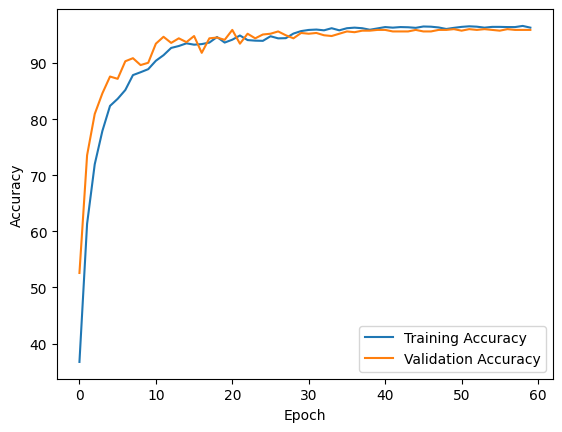

In [140]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

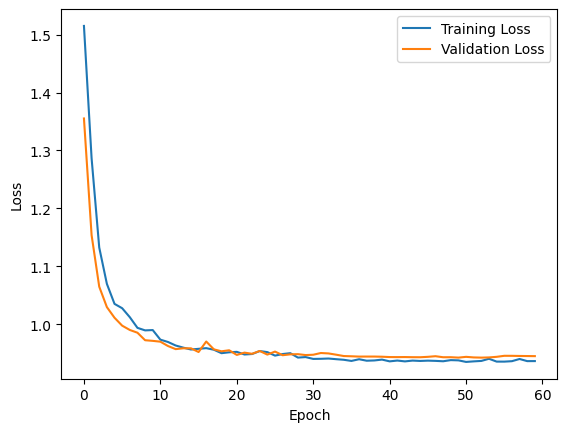

In [141]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [138]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, \
            x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, \
            x10_batch, x11_batch, x12_batch, y_batch in dataloader:
            
            x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, \
            x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, \
            x10_batch, x11_batch, x12_batch, y_batch = (
                x0_batch.to(device),
                x1_batch.to(device),
                x2_batch.to(device),
                x3_batch.to(device),
                x4_batch.to(device),
                x5_batch.to(device),
                x6_batch.to(device),
                x7_batch.to(device),
                x8_batch.to(device),
                x9_batch.to(device),
                x10_batch.to(device),
                x11_batch.to(device),
                x12_batch.to(device),
                y_batch.to(device)
            )
            
            outputs = model(x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, 
                             x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, 
                             x10_batch, x11_batch, x12_batch)
            
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    class_report = classification_report(all_targets, all_predictions, zero_division=0)

    return accuracy, conf_matrix, class_report


In [139]:
accuracy, conf_matrix, class_report = evaluate_model(model, test_dataloader)

print(f'Validation Accuracy: {accuracy}\n')
print(f'Confusion Matrix:\n{conf_matrix}\n')
print(f'Classification Report:\n{class_report}\n')


Validation Accuracy: 0.9591280653950953

Confusion Matrix:
[[407   2   0  11   0]
 [  1  77   0   1   1]
 [  1   0  33   0   0]
 [  0   1  12 169   0]
 [  0   0   0   0  18]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       420
           1       0.96      0.96      0.96        80
           2       0.73      0.97      0.84        34
           3       0.93      0.93      0.93       182
           4       0.95      1.00      0.97        18

    accuracy                           0.96       734
   macro avg       0.91      0.97      0.94       734
weighted avg       0.96      0.96      0.96       734


